In [1]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition## for explainer
from lime import lime_tabular

In [2]:
# Don't have any existing modeling code on hand to start from, so grabbing the basic components from this tutorial
# https://towardsdatascience.com/machine-learning-with-python-regression-complete-tutorial-47268e546cea

In [3]:
analysis12M = pd.read_csv('GBC train 12M.csv')

In [4]:
# Get down to just the columns we need - this has extra Time Offset columns 
analysis12M = analysis12M.loc[:, ['Month', 'max_ratio', 'CLI', 'BCI', 'CCI', 'Employment Rate', 'CPI',
       'LTI Rate', 'PPI', 'STI Rate', 'Unemployment Rate']]

analysis12M.set_index('Month', inplace = True)

analysis12M.head()

,max_ratio,CLI,BCI,CCI,Employment Rate,CPI,LTI Rate,PPI,STI Rate,Unemployment Rate
Month,,,,,,,,,,
2016-01-01,4.573529,0.7341,0.18380,1.1536,-1.855,-1.39652,1.88,-0.29642,0.16,5.7
2016-02-01,5.147059,0.6263,-0.03513,1.1561,-1.955,-0.96828,1.98,-0.08084,0.15,5.5
2016-03-01,5.036765,0.5192,-0.18522,1.0509,-1.872,-0.37888,2.04,0.35030,0.14,5.4
2016-04-01,5.330882,0.4155,-0.22597,0.9912,-1.489,-0.17636,1.94,0.08080,0.13,5.4
2016-05-01,4.926471,0.3060,-0.16427,0.9036,-1.183,0.33250,2.20,1.42820,0.15,5.6


In [5]:
## split data
dtf_train, dtf_test = model_selection.train_test_split(analysis12M, 
                      test_size=0.2)

## print info
print("X_train shape:", dtf_train.drop("max_ratio",axis=1).shape, "| X_test shape:", dtf_test.drop("max_ratio",axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train["max_ratio"]),2), "| y_test mean:", round(np.mean(dtf_test["max_ratio"]),2))
print(dtf_train.shape[1], "features:", dtf_train.drop("max_ratio",axis=1).columns.to_list())

X_train shape: (38, 9) | X_test shape: (10, 9)
y_train mean: 5.32 | y_test mean: 5.43
10 features: ['CLI', 'BCI', 'CCI', 'Employment Rate', 'CPI', 'LTI Rate', 'PPI', 'STI Rate', 'Unemployment Rate']


In [6]:
## scale X
scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
X = scalerX.fit_transform(dtf_train.drop("max_ratio", axis=1))

dtf_scaled= pd.DataFrame(X, columns=dtf_train.drop("max_ratio", 
                        axis=1).columns, index=dtf_train.index)  

## scale max_ratio
scalerY = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
dtf_scaled['max_ratio'] = scalerY.fit_transform(
                    dtf_train['max_ratio'].values.reshape(-1,1))

dtf_scaled.head()

,CLI,BCI,CCI,Employment Rate,CPI,LTI Rate,PPI,STI Rate,Unemployment Rate,max_ratio
Month,,,,,,,,,,
2017-10-01,-0.550723,-0.310084,-0.750249,-0.066773,0.017259,-1.260606,-0.461527,-0.095238,0.228571,1.159281
2019-11-01,0.137777,0.421272,0.390475,1.157520,1.215485,2.036364,1.423098,1.851852,-1.028571,-0.205988
2017-08-01,-0.745066,-0.440581,-0.831215,-0.070334,-0.085001,-1.745455,-0.615375,-0.084656,0.228571,0.416766
2016-12-01,-0.687515,-0.802452,-0.558713,-0.490302,-0.587592,-0.096970,-0.833325,-0.285714,0.342857,-1.044311
2019-06-01,0.708865,0.625183,0.478005,0.935707,1.209783,1.527273,1.423098,1.460317,-0.800000,0.201198


<AxesSubplot:xlabel='selection', ylabel='features'>

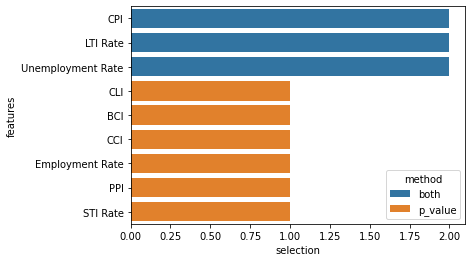

In [7]:
X = dtf_train.drop("max_ratio", axis=1).values
y = dtf_train["max_ratio"].values
feature_names = dtf_train.drop("max_ratio", axis=1).columns

## p-value
selector = feature_selection.SelectKBest(score_func=  
               feature_selection.f_regression, k=9).fit(X,y)
pvalue_selected_features = feature_names[selector.get_support()]

## regularization
selector = feature_selection.SelectFromModel(estimator= 
              linear_model.Ridge(alpha=1.0, fit_intercept=True), 
                                 max_features=9).fit(X,y)
regularization_selected_features = feature_names[selector.get_support()]
 
## plot
dtf_features = pd.DataFrame({"features":feature_names})
dtf_features["p_value"] = dtf_features["features"].apply(lambda x: "p_value" if x in pvalue_selected_features else "")
dtf_features["num1"] = dtf_features["features"].apply(lambda x: 1 if x in pvalue_selected_features else 0)
dtf_features["regularization"] = dtf_features["features"].apply(lambda x: "regularization" if x in regularization_selected_features else "")
dtf_features["num2"] = dtf_features["features"].apply(lambda x: 1 if x in regularization_selected_features else 0)
dtf_features["method"] = dtf_features[["p_value","regularization"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]
dtf_features["method"] = dtf_features["method"].apply(lambda x: "both" if len(x.split()) == 2 else x)

sns.barplot(y="features", x="selection", hue="method", 
            data=dtf_features.sort_values("selection", ascending=False), dodge=False)

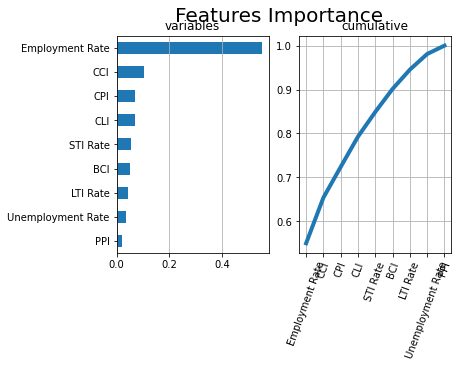

In [8]:
X = dtf_train.drop("max_ratio", axis=1).values
y = dtf_train["max_ratio"].values
feature_names = dtf_train.drop("max_ratio", axis=1).columns.tolist()

## call model
model = ensemble.GradientBoostingRegressor()

## Importance
model.fit(X,y)
importances = model.feature_importances_## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')

dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
                kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)), 
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

In [9]:
# Okay, now we know what is worth keeping
X_names = ['Employment Rate', 'CCI', 'STI Rate', 'CLI', 'CPI']
X_train = dtf_train[X_names].values
y_train = dtf_train["max_ratio"].values
X_test = dtf_test[X_names].values
y_test = dtf_test["max_ratio"].values

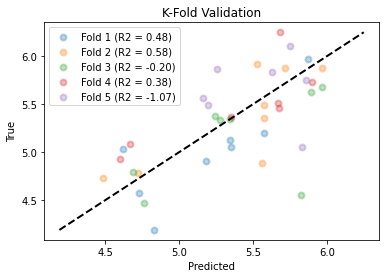

In [10]:
## call model
#model = linear_model.LinearRegression()## K fold validation
model = ensemble.GradientBoostingRegressor()

scores = []
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train],
                 y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    plt.scatter(prediction, true, lw=2, alpha=0.3, 
                label='Fold %d (R2 = %0.2f)' % (i,score))
    i = i+1
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend()
plt.show()

In [11]:
## train
model.fit(X_train, y_train)
## test
predicted = model.predict(X_test)

#predicted = scalerY.inverse_transform( 
#                  predicted.reshape(-1,1) ).reshape(-1)

In [12]:
predicted

array([5.76378138, 5.25486768, 5.06056394, 4.90525849, 5.46931206,
       5.75941891, 5.06056394, 5.43338815, 4.92166897, 5.69223351])

In [13]:
y_test

array([5.60661765, 5.17647059, 5.40441176, 5.14705882, 5.29411765,
       5.64338235, 5.42279412, 5.79044118, 5.33088235, 5.44117647])

In [14]:
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(y_test, predicted), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-predicted)/predicted)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, predicted))))

## residuals
residuals = y_test - predicted
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = y_test[max_idx], predicted[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): -0.95
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.05
Mean Absolute Error (Σ|y-pred|/n): 0
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0
Max Error: 0


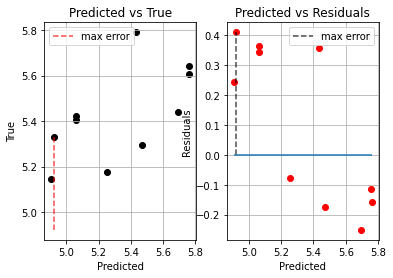

In [15]:
## Plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2)
from statsmodels.graphics.api import abline_plot
ax[0].scatter(predicted, y_test, color="black")
#abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error, color='red', linestyle='--', alpha=0.7, label="max error")
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
## Plot predicted vs residuals
ax[1].scatter(predicted, residuals, color="red")
ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(predicted), xmax=np.max(predicted))
ax[1].legend()
plt.show()

In [16]:
###### GENERATE PREDICTIONS
current = pd.read_csv('OECD input data - monthly Jan 2018 onward.csv')
current.set_index('TIME', inplace = True)
# current.head()

inPredict = current[len(current)-1:len(current)]
inPredict = inPredict[X_names].values
inPredict

outPredict = model.predict(inPredict)
outPredict

array([5.77133976])